In [1]:
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm

VERSION = "v0"

In [2]:
df = pd.read_csv("data/train_tp.csv")

num_targets = df["species_id"].max() + 1

print(df.shape, num_targets)
df["species_id"].value_counts()

(1216, 7) 24


23    100
17     68
12     50
1      50
3      50
4      50
5      50
6      50
7      50
8      50
10     50
11     50
13     50
14     50
15     50
16     50
18     50
21     50
0      50
22     44
19     43
20     40
2      37
9      34
Name: species_id, dtype: int64

In [3]:
df = df.groupby("recording_id").agg({"species_id": list, "t_min": "min", "t_max": "max", "f_min": "min", "f_max": "max"}).reset_index()

df["species_id"].apply(len).value_counts()

1    1065
2      55
3       8
4       3
5       1
Name: species_id, dtype: int64

In [4]:
TRAIN_PATH = "data/train/"
NUM_FOLDS = 4

all_ids = [x.split(".")[0] for x in os.listdir(TRAIN_PATH) if "." in x]
df = pd.DataFrame({"recording_id": all_ids}).merge(df, on="recording_id", how="left")
df = df.sort_values("recording_id").reset_index(drop=True)
df["fold"] = df.index % NUM_FOLDS
df

,recording_id,species_id,t_min,t_max,f_min,f_max,fold
0,00204008d,NaN,NaN,NaN,NaN,NaN,0
1,003b04435,NaN,NaN,NaN,NaN,NaN,1
2,003bec244,[14],44.5440,45.1307,2531.25,5531.25,2
3,005f1f9a5,NaN,NaN,NaN,NaN,NaN,3
4,006ab765f,[23],39.9615,46.0452,7235.16,11283.40,0
...,...,...,...,...,...,...,...
4722,ffc6031f8,NaN,NaN,NaN,NaN,NaN,2
4723,ffd88cd84,NaN,NaN,NaN,NaN,NaN,3
4724,ffebe7313,NaN,NaN,NaN,NaN,NaN,0
4725,fff163132,NaN,NaN,NaN,NaN,NaN,1


In [5]:
models = ["ahmet", "toda"] #, "kuto"]
cols = [f"s{c}" for c in range(24)]

oof_df = pd.read_csv(f"team/oof_ahmet_{VERSION}.csv")[["recording_id", "patch"]]

for m in models:
    tmp_df = pd.read_csv(f"team/oof_{m}_{VERSION}.csv").rename(columns={k: f"{k}_{m}" for k in cols})
    oof_df = oof_df.merge(tmp_df, on=["recording_id", "patch"])
    
oof_df.head()

,recording_id,patch,s0_ahmet,s1_ahmet,s2_ahmet,s3_ahmet,s4_ahmet,s5_ahmet,s6_ahmet,s7_ahmet,...,s14_toda,s15_toda,s16_toda,s17_toda,s18_toda,s19_toda,s20_toda,s21_toda,s22_toda,s23_toda
0,00204008d,0,0.005445,0.002437,0.010304,0.008519,0.001837,0.035252,0.010478,0.002146,...,0.002321,0.009361,0.005990,0.001955,0.243064,0.020363,0.003620,0.002275,0.001519,0.011506
1,00204008d,1,0.005710,0.002157,0.005864,0.011758,0.001043,0.006342,0.096277,0.002839,...,0.003159,0.007292,0.006715,0.002297,0.074086,0.014473,0.004229,0.001539,0.001868,0.014385
2,00204008d,2,0.006255,0.004526,0.004898,0.010953,0.001002,0.003282,0.054326,0.001174,...,0.003954,0.007742,0.004866,0.004331,0.009434,0.005945,0.008517,0.000962,0.001806,0.008705
3,00204008d,3,0.005256,0.003254,0.004018,0.108886,0.001196,0.009608,0.010181,0.002633,...,0.001633,0.007413,0.005257,0.002083,0.041970,0.007374,0.003777,0.001132,0.001587,0.013665
4,00204008d,4,0.004667,0.004370,0.002057,0.558993,0.001339,0.038850,0.032057,0.002459,...,0.001495,0.007474,0.006600,0.002001,0.091851,0.141096,0.004039,0.001186,0.001421,0.015150


In [6]:
y = np.zeros((df.shape[0], 24))

for i in range(df.shape[0]):
    if type(df["species_id"].values[i]) == list:
        for j in df["species_id"].values[i]:
            y[i, j] = 1
            
            
df = df.merge(oof_df, on="recording_id")            
df.shape, y.shape

((37816, 56), (4727, 24))

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import label_ranking_average_precision_score as lrap
import itertools

y_pred = np.zeros_like(y)

weights = np.zeros((24, len(models)))

for c in range(24):
    cols = [f"s{c}_{m}" for m in models]
    best = None
    best_auc = 0
    for w in itertools.product(*(len(models)*[[1]])):
        w = np.array(list(w))
        
        sum_w = w.sum()
        if sum_w > 0:
            df[f"s{c}"] = (df[cols]*w).sum(axis=1)/sum_w
            
            pred = df.groupby("recording_id")[f"s{c}"].max().reset_index().sort_values("recording_id")
            auc = roc_auc_score(y[:, c], pred[f"s{c}"])
            if auc > best_auc:
                best = w
                best_auc = auc
        
    weights[c] = best
    df[f"s{c}"] = (df[cols]*best).sum(axis=1)/best.sum()
    y_pred[:, c] = df.groupby("recording_id")[f"s{c}"].max().reset_index().sort_values("recording_id")[f"s{c}"]

    print(c, best, round(best_auc, 4))
    
print("WLRAP", round(lrap(y, y_pred, sample_weight=y.sum(axis=1)), 4))

0 [1 1] 0.9758
1 [1 1] 0.9615
2 [1 1] 0.9889
3 [1 1] 0.6616
4 [1 1] 0.9806
5 [1 1] 0.985
6 [1 1] 0.998
7 [1 1] 0.9056
8 [1 1] 0.9925
9 [1 1] 0.9862
10 [1 1] 0.9954
11 [1 1] 0.9758
12 [1 1] 0.9499
13 [1 1] 0.9978
14 [1 1] 0.9757
15 [1 1] 0.9592
16 [1 1] 0.9943
17 [1 1] 0.9873
18 [1 1] 0.9542
19 [1 1] 0.9983
20 [1 1] 0.9949
21 [1 1] 0.9892
22 [1 1] 0.993
23 [1 1] 0.9915
WLRAP 0.8172


In [8]:
cols = [f"s{c}" for c in range(24)]

test_df = pd.read_csv(f"team/test_ahmet_{VERSION}.csv")[["recording_id", "patch"]]

for m in models:
    test_df = test_df.merge(pd.read_csv(f"team/test_{m}_{VERSION}.csv").rename(columns={k: f"{k}_{m}" for k in cols}), 
                            on=["recording_id", "patch"])

for c in range(24):
    test_df[f"s{c}"] = (test_df[[f"s{c}_{m}" for m in models]]*weights[c]).sum(axis=1)/weights[c].sum()

print(test_df.shape, test_df.shape[0]/1992)
test_df[["recording_id", "patch"] + cols].head()

(15936, 74) 8.0


,recording_id,patch,s0,s1,s2,s3,s4,s5,s6,s7,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,aba967d65,0,0.005165,0.005089,0.922963,0.398773,0.000994,0.012588,0.004485,0.004410,...,0.003642,0.008889,0.004094,0.012062,0.001296,0.011298,0.048812,0.002841,0.001522,0.005541
1,aba967d65,1,0.010603,0.006237,0.927419,0.496406,0.000928,0.014274,0.003268,0.002876,...,0.004236,0.006575,0.003954,0.011142,0.001221,0.011243,0.019709,0.003004,0.001421,0.046317
2,aba967d65,2,0.006512,0.027876,0.911115,0.432194,0.001179,0.024190,0.002374,0.002595,...,0.003616,0.007160,0.005954,0.010625,0.001601,0.018287,0.012314,0.003708,0.001714,0.049795
3,aba967d65,3,0.004881,0.015696,0.911272,0.347682,0.001021,0.028819,0.003103,0.004207,...,0.003548,0.008108,0.005077,0.004345,0.001706,0.005403,0.005510,0.003120,0.001678,0.002623
4,aba967d65,4,0.002671,0.006762,0.918293,0.513532,0.000926,0.014619,0.003672,0.004832,...,0.003077,0.006563,0.003264,0.005177,0.001207,0.005503,0.007381,0.003090,0.001477,0.027681


In [9]:
df = df.groupby("recording_id")[cols].max().reset_index().sort_values("recording_id")

In [10]:
class_weights = df[cols].values.mean(axis=0)/y.mean(axis=0)
class_weights

array([ 8.00530147, 13.96620842,  9.34453711, 47.65303312,  5.68171604,
        7.6049722 ,  6.5269314 , 16.82684864,  5.83680848, 14.50548374,
       10.26643404, 12.92315061, 12.85615484,  8.54494757,  8.66683652,
       11.84536097,  7.41704225,  7.26683291, 19.31750721,  6.74239948,
       16.87463038,  6.97044404,  3.40283698,  7.50213525])

In [11]:
def metric(y, y_pred):
    total_w = 0
    pos_w = 0
    for i in range(y.shape[0]):
        top5 = np.argsort(-y_pred[i])[:4]
        
        for c in np.where(y[i] == 1)[0]:
            total_w += class_weights[c]
            if c in top5:
                pos_w += class_weights[c]
    return pos_w/total_w
        
metric(y, df[cols].values)

0.9622039654864432

In [12]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logit(x):
    return -np.log(1/x - 1)

def postprocess(y_pred):
    y_post = y_pred.copy()
    y_post = logit(y_post)
    
    y_post[:, 0] = y_post[:, 0]*1.1
    y_post[:, 3] = y_post[:, 3]*0.5 + 0.5
    y_post[:, 5] = y_post[:, 5]*0.7
    y_post[:, 7] = y_post[:, 7]*0.5 + 0.5
    y_post[:, 11] = y_post[:, 11]*1.5
    y_post[:, 15] = y_post[:, 15]*0.7
    y_post[:, 17] = y_post[:, 17]*0.7 + 0.5
    
    y_post = sigmoid(y_post)
    
    return y_post


np.round(metric(y, postprocess(df[cols].values)), 4)

0.9848

In [13]:
print("WLRAP", round(lrap(y, y_pred, sample_weight=y.sum(axis=1)), 4))
print("WLRAP", round(lrap(y, postprocess(y_pred), sample_weight=y.sum(axis=1)), 4))

WLRAP 0.8172
WLRAP 0.8186


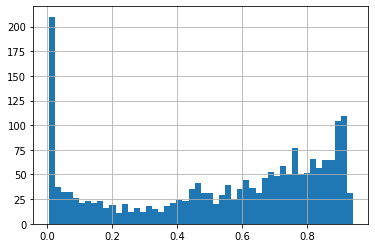

In [14]:
sub_df = test_df.groupby("recording_id")[cols].max().reset_index()
sub_df["s3"].hist(bins=50)

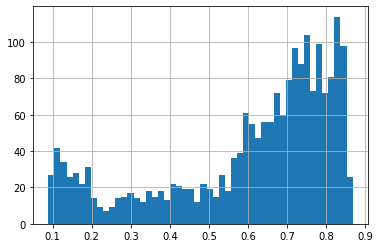

In [15]:
sub_df[cols] = postprocess(sub_df[cols].values)
sub_df["s3"].hist(bins=50)

In [16]:
sub_df.to_csv("calibrated_sub.csv", index=False, columns=["recording_id"] + cols)